## Description of the dataset

The dataset under consideration, ["90,000+ Cars Data From 1970 to 2024"](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024), offers a comprehensive collection of car-related information spanning several decades. With over 90,000 entries and 10 columns, this dataset provides a rich source of data for analysis. The original dataset comprising 100,000 scraped used car listings was collected and cleaned by Aditya.

## Description of the features

In [1]:
# !pip install jupyter findspark
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install pyspark

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CarsData_analysis").getOrCreate()
print(spark)

/usr/local/lib/python3.6/dist-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [3]:
df = spark.read.csv("hdfs://hadoop-master:9000/cars/CarsData.csv", header=True, inferSchema=True)

Let's take a glance at the data:

In [4]:
df.show(5)

+-------------+----+-----+------------+-------+--------+---+----+----------+------------+
|        model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|Manufacturer|
+-------------+----+-----+------------+-------+--------+---+----+----------+------------+
|          I10|2017| 7495|      Manual|  11630|  Petrol|145|60.1|       1.0|      hyundi|
|         Polo|2017|10989|      Manual|   9200|  Petrol|145|58.9|       1.0|  volkswagen|
|     2 Series|2019|27990|   Semi-Auto|   1614|  Diesel|145|49.6|       2.0|         BMW|
| Yeti Outdoor|2017|12495|      Manual|  30960|  Diesel|150|62.8|       2.0|       skoda|
|       Fiesta|2017| 7999|      Manual|  19353|  Petrol|125|54.3|       1.2|        ford|
+-------------+----+-----+------------+-------+--------+---+----+----------+------------+
only showing top 5 rows



Data comprise 10 features:
1. model
2. year
3. price
4. transmissions
5. mileage,
6. fuelType,
7. tax,
8. mpg,
9. engineSize,
10. Manufacturer

6 of them being numerical and 4 categorical.

## Exploratory Analysis of the features

In [5]:
df.printSchema()

root
 |-- model: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)
 |-- Manufacturer: string (nullable = true)



In [6]:
num_cols = ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']
cat_cols = ['model', 'transmission', 'fuelType',  'Manufacturer']

Now we will explore the distributions of numerical data. For further analysis let's convert pyspark.sql.dataframe to pandas.dataframe

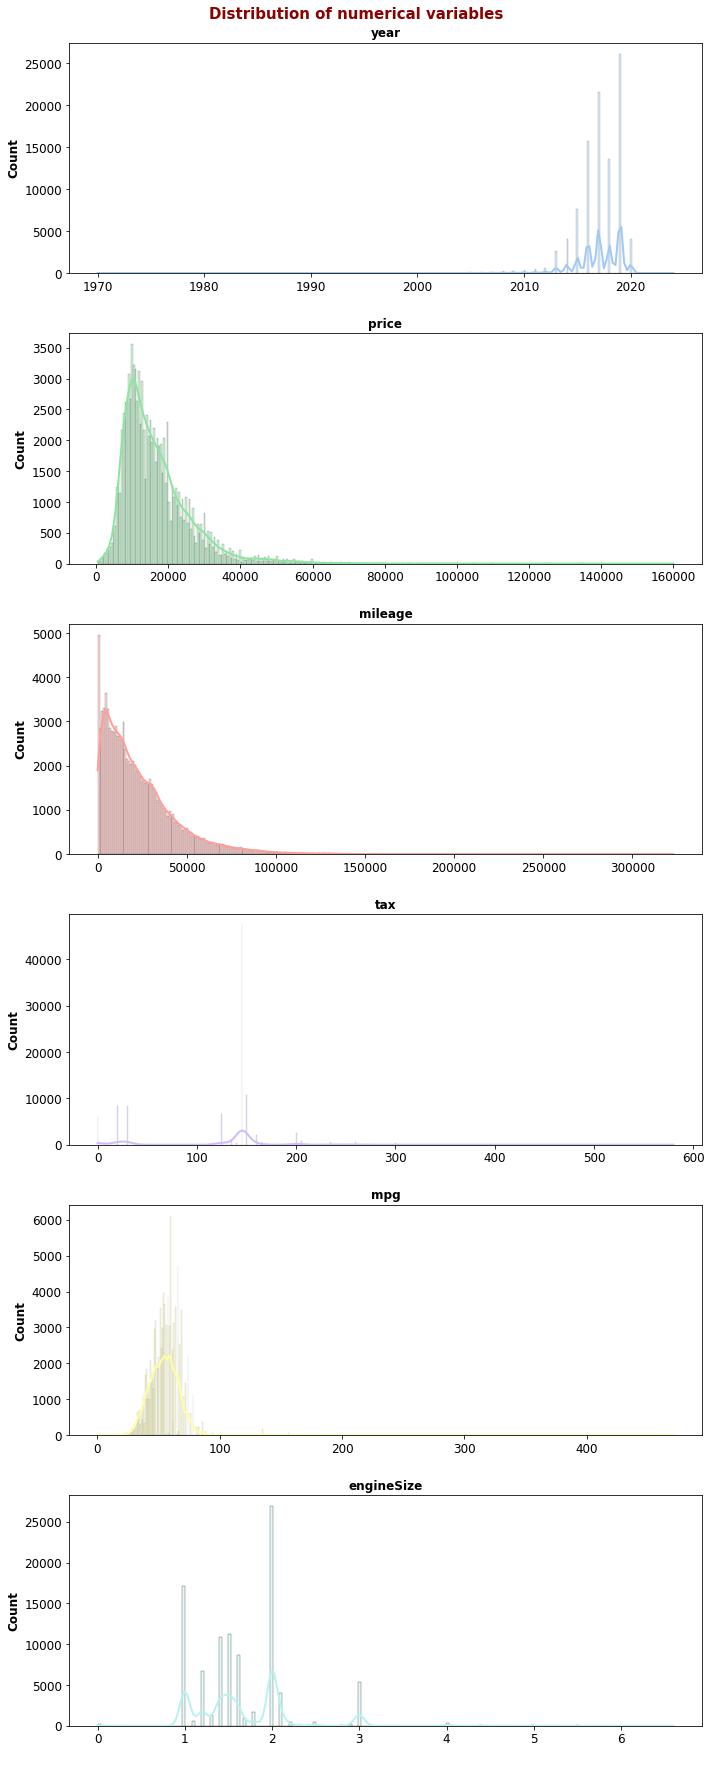

In [7]:
df = df.toPandas()

fig, axes = plt.subplots(6, 1, figsize=(10, 25))
axes = axes.flat # flatten the axis to iterate over them

for i, col in enumerate(num_cols):
    sns.histplot(data=df,
        x=col,
        stat='count',
        kde=True, # smoothen the histogram
        color=sns.color_palette('pastel6')[i],
        line_kws={'linewidth': 2},
        alpha=0.4,
        ax=axes[i])

    axes[i].set_xlabel(" ")
    axes[i].set_ylabel("Count", fontsize=12, fontweight='bold', color='black')
    axes[i].set_title(col, fontsize=12, fontweight='bold', color='black')
    axes[i].tick_params(labelsize=12)

fig.suptitle('Distribution of numerical variables', fontsize=15, fontweight='bold', color='darkred')
fig.tight_layout()
fig.subplots_adjust(top=0.96)
plt.show()

Great. Let's take a look at the distribution of categorical variables.

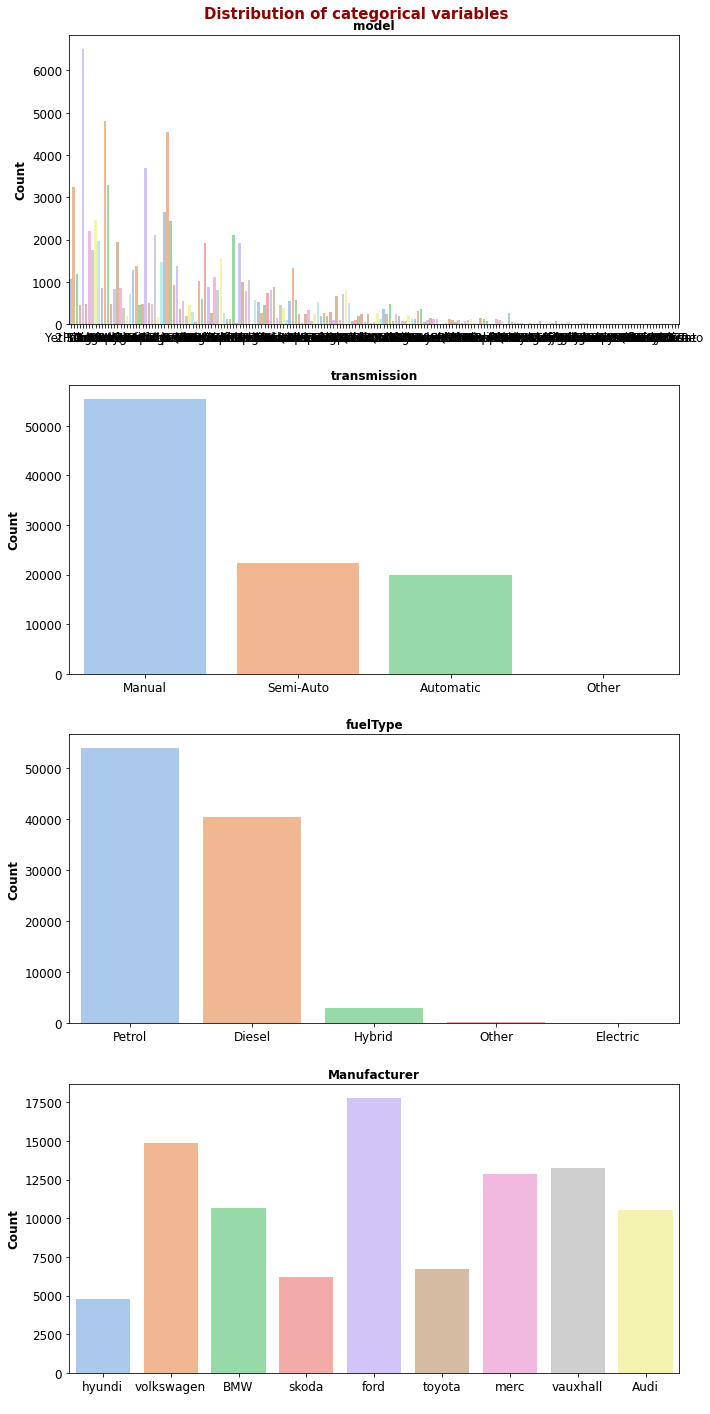

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
axes = axes.flat

for i, col in enumerate(cat_cols):
    # add countplot for each categorical column
    sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
    axes[i].set_xlabel(" ")
    axes[i].set_ylabel("Count", fontsize=12, fontweight='bold', color='black')
    axes[i].set_title(col, fontsize=12, fontweight='bold', color='black')
    axes[i].tick_params(labelsize=12)

fig.suptitle('Distribution of categorical variables', fontsize=15, fontweight='bold', color='darkred')
fig.tight_layout()
fig.subplots_adjust(top=0.96)
plt.show()

As we can see, there is only a relatively small variety of categories in all columns, except for the model. The plot for the model feauture is quite messy. We will need to figure out a way to make it more convienient, such that it is easier for user to interpret and browse

In [9]:
print(df.model.nunique()) # number of unique values in model column
# print only values of model column that constitute over 1% of the data
models_over_1percent = df.model.value_counts(normalize=True)[df.model.value_counts(normalize=True) > 0.01]
print(len(models_over_1percent))
# sum of all values that are over 1%
print(models_over_1percent.sum())

195
29
0.6588955297199934


That's interesting, isn't it? 15% of all models contribute to almost 66% of the whole dataset! Let's find the most informative 

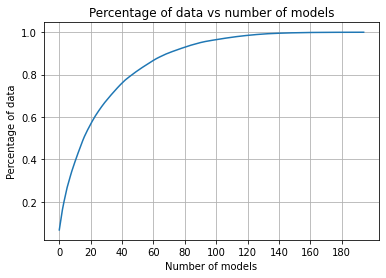

In [10]:
# plot number of models vs their count
data_percent_vs_num_of_models = []
for i in range(len(df.model.value_counts())):
    data_percent_vs_num_of_models.append(df.model.value_counts(normalize=True).iloc[:i+1].sum())
plt.plot([i for i in range(len(df.model.value_counts()))], data_percent_vs_num_of_models)
plt.grid()
plt.xticks([i for i in range(0, len(df.model.value_counts()), 20)])
plt.xlabel('Number of models')
plt.ylabel('Percentage of data')
plt.title('Percentage of data vs number of models')
plt.show()

As we can see, the elbow is not obvious, however we can select a desired threshold value easily or even ignore this column and treat manufacturer one as sufficient.

Furthermore, we can look for correlation between pairs of variables using pairplot!

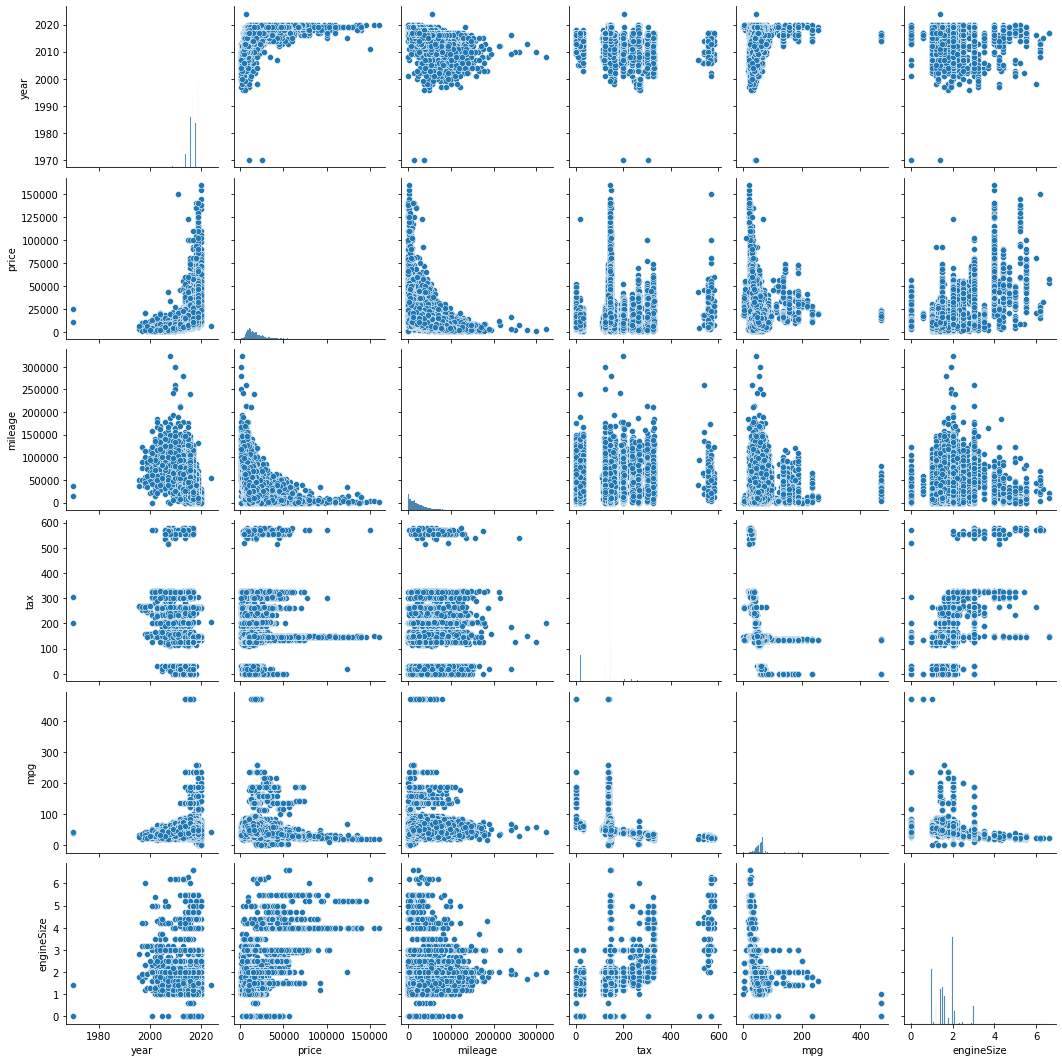

In [11]:
import seaborn as sns

sns.pairplot(df)

Great, lets present this correlation in heatmap form:

Text(0.5, 1.0, 'Correlation Plot')

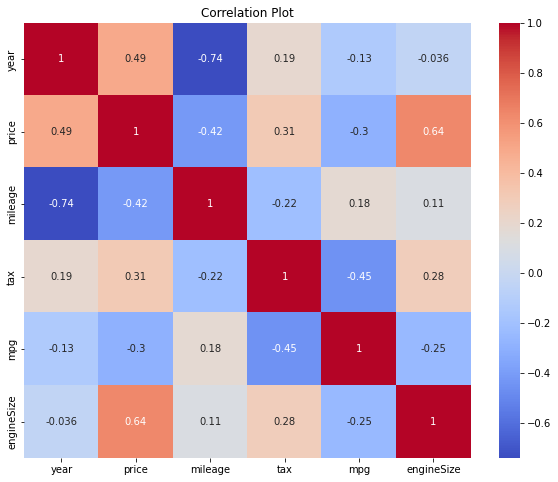

In [12]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot')


Based on the above plot we can notice that price is highly positively correlated with engineSize and year of production. Both of these findings are quite intuitive. Additionally, we can see that mileage is strongly negatively correlated to price. It is clear that used cars and high prices don't go along.